# Full SLURM data Analysis (Underutilization function, multiple distributions)

In [ ]:
import ICER_Data as ice

myslurm = ice.SLURM.read("filename.csv")

data = myslurm.getjobdistribution()
myslurm.showjobdistribution()

In [25]:
data2 = myslurm.getUnderutilized(overide defaults)
data2

NameError: name 'myslurm' is not defined

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import timedelta

In [62]:
slurm_clean = pd.read_csv("/mnt/scratch/alkhali7/clean_slurm.csv")

In [63]:
slurm_clean.head()

,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,...,CPUTimeRAW,ReqCPUS,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES
0,336748,92134676,user_272,group_154,2023-10-02T19:49:11,2023-10-02T19:51:56,2023-10-02T23:20:44,03:28:48,COMPLETED,account_016,...,12528,1,1,200G,2281632K,1,1,acm-025,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1"
1,336736,92134676,user_272,group_154,2023-10-02T19:49:11,2023-10-02T19:51:51,2023-10-02T23:34:24,03:42:33,COMPLETED,account_016,...,13353,1,1,200G,2323692K,1,1,amr-204,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1"
2,336733,92134676,user_272,group_154,2023-10-02T19:49:11,2023-10-02T19:49:16,2023-10-02T23:38:41,03:49:25,COMPLETED,account_016,...,13765,1,1,200G,2279580K,1,1,amr-241,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1"
3,336730,92134676,user_272,group_154,2023-10-02T19:49:11,2023-10-02T19:49:16,2023-10-02T23:40:47,03:51:31,COMPLETED,account_016,...,13891,1,1,200G,2280680K,1,1,amr-241,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1"
4,336727,92134676,user_272,group_154,2023-10-02T19:49:11,2023-10-02T19:49:16,2023-10-02T23:47:02,03:57:46,COMPLETED,account_016,...,14266,1,1,200G,2357408K,1,1,amr-241,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1"


In [64]:
slurm_clean.shape

(153106, 27)

In [65]:
# slurm_clean.info()

In [66]:
# set(slurm_clean.State)      # we have states that are cancelled 0, 0038439, etc, out of memory, completed

# Preprocessing data 

- Converting 'Submit', 'Start' columns to datatime
- Dropping Nan values for 'MaxRSS' column (NAN MaxRSS representing jobs not started (cancelled or out of memory)
- Converting Memory strings units for 'ReqMem' and 'MaxRSS' columns into one unit that is MegaBytes
- Parsing string times in 'Timelimit' and 'Elapsed' columns into timedelta datatype
- Converting 'Timelimit' and 'Elapsed' columns into hours unit

In [67]:
# Preprocessing
slurm_clean['Submit'] = pd.to_datetime(slurm_clean['Submit'])
slurm_clean['Start'] = pd.to_datetime(slurm_clean['Start'])

slurm_clean = slurm_clean.dropna(subset=['MaxRSS'])   # dropping nan used memory (MaxRSS) because it is when jobs where state was cancelled, out of memory


In [68]:
# set(slurm_clean.MaxRSS)

In [69]:
# set(slurm_clean.State)

In [70]:
# # convert ReqMem to a uniform measurement (assuming 'M' for MB and 'G' for GB and 'K' for KB)
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T

In [71]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

slurm_clean['ReqMem_MB'] = slurm_clean['ReqMem'].apply(convert_memory)
slurm_clean['MaxRSS_MB'] = slurm_clean['MaxRSS'].apply(convert_memory)

# # Filter out rows where 'State' is "Cancelled" or Unknown
slurm_clean = slurm_clean[slurm_clean['State'] != 'Cancelled']
slurm = slurm_clean[slurm_clean['Start']!= 'Unknown']

# slurm_clean.head()

In [72]:
# Function to parse time data columns: TimeLimit and Elapsed
def parse_time_string(time_str):
    """Convert a time string into a timedelta object."""
    days = 0
    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

# Convert Timelimit and Elapsed to timedeltas
slurm_clean['Timelimit'] = slurm_clean['Timelimit'].apply(parse_time_string)
slurm_clean['Elapsed'] = slurm_clean['Elapsed'].apply(parse_time_string)

# Converting Timelimit and Elapsed to time delts
slurm_clean['Elapsed'] = pd.to_timedelta(slurm_clean['Elapsed']).dt.total_seconds() / 3600  # Convert Elapsed time to hours
slurm_clean['Timelimit'] = pd.to_timedelta(slurm_clean['Timelimit']).dt.total_seconds() / 3600  # Convert Elapsed time to hours

In [73]:
print("Data Shape after cleaning and preprocessing:",slurm_clean.shape)

Data Shape after cleaning and preprocessing: (129449, 29)


In [74]:
slurm_clean.head()

,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,...,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB
0,336748,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:51:56,2023-10-02T23:20:44,3.480000,COMPLETED,account_016,...,1,200G,2281632K,1,1,acm-025,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1",200000.0,2281.632
1,336736,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:51:51,2023-10-02T23:34:24,3.709167,COMPLETED,account_016,...,1,200G,2323692K,1,1,amr-204,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1",200000.0,2323.692
2,336733,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:49:16,2023-10-02T23:38:41,3.823611,COMPLETED,account_016,...,1,200G,2279580K,1,1,amr-241,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1",200000.0,2279.580
3,336730,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:49:16,2023-10-02T23:40:47,3.858611,COMPLETED,account_016,...,1,200G,2280680K,1,1,amr-241,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1",200000.0,2280.680
4,336727,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:49:16,2023-10-02T23:47:02,3.962778,COMPLETED,account_016,...,1,200G,2357408K,1,1,amr-241,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1",200000.0,2357.408


In [15]:
# EDA plots on full cleaned SLURM data

In [16]:
# Elapsed Time Distribution
# Purpose: To understand the distribution of job durations. This could highlight whether most jobs are short-lived or if there are many long-running jobs.




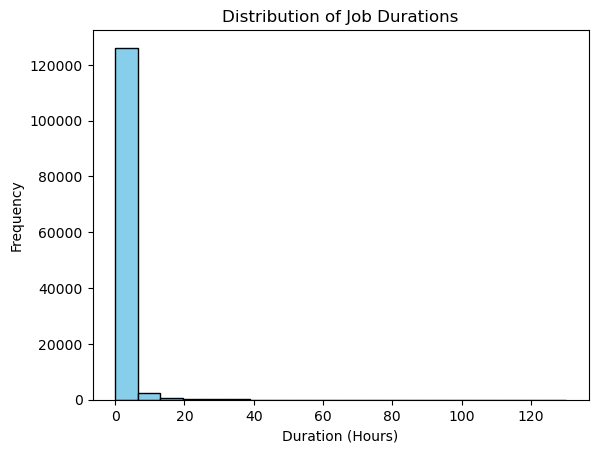

In [41]:
plt.hist(slurm_clean['Elapsed'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Job Durations')
plt.xlabel('Duration (Hours)')
plt.ylabel('Frequency')
plt.show()
# Comment: most jobs having very short durations and a few jobs taking much longer.

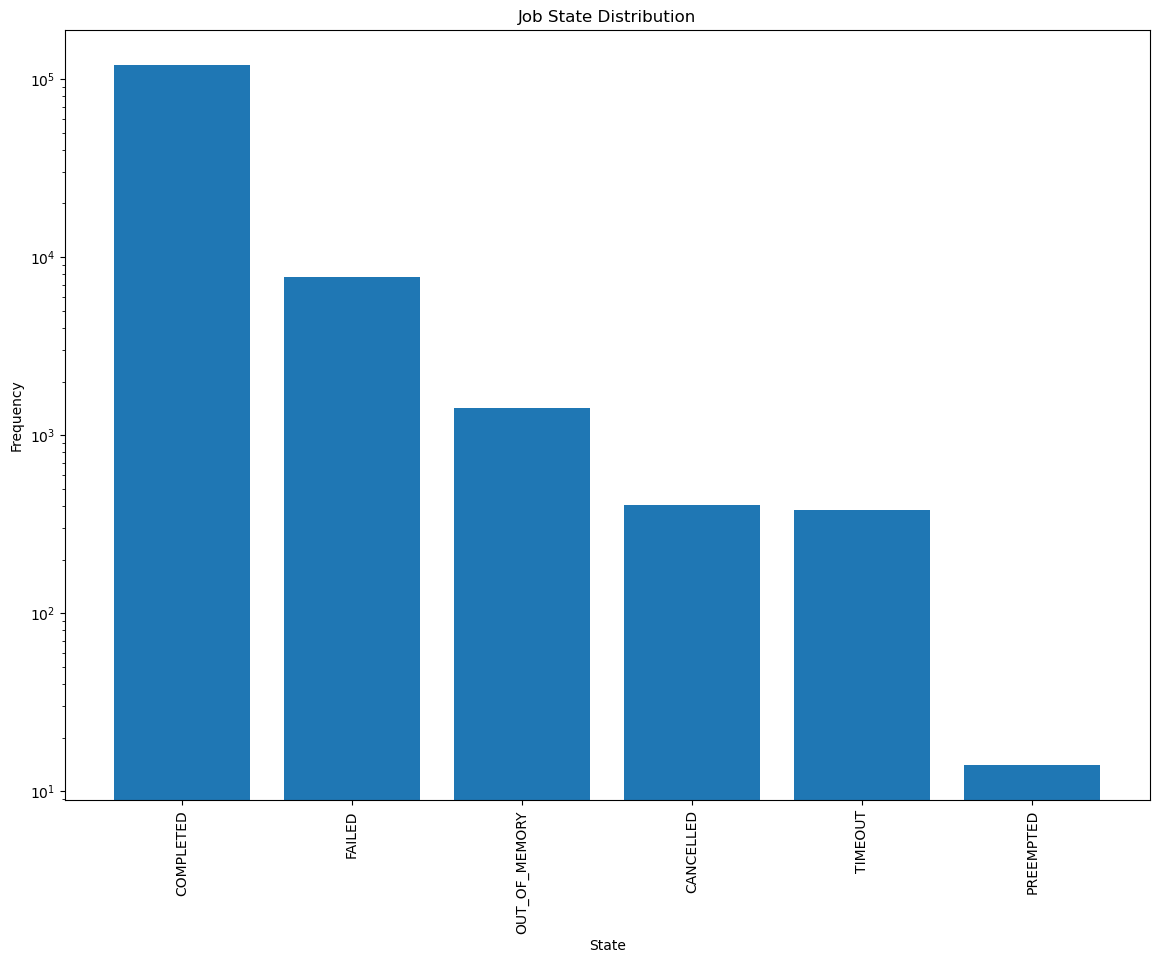

In [76]:
# Job State Distribution

# Replace states that contain 'CANCELLED' with the word 'CANCELLED'
slurm_clean['State'] = slurm_clean['State'].str.replace(r'\s+by\s+\d+$', '', regex=True)


# calculate the count of each state
state_count = slurm_clean.State.value_counts()

# create the bar chart
plt.figure(figsize=(14,10))
plt.bar(state_count.index, state_count.values)
plt.title('Job State Distribution')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Job Submission Time Trend
slurm_clean.Submit

# OLD Function Identifying underutilized SLURM jobs on Scaled Metric

In [46]:
def FindUnterutilizerSLURM(data, time_threshold, cpu_threshold, nodes_threshold, memory_threshold):
    """
    Identifies underutilized SLURM job resources based on specified thresholds for time, CPU, nodes, and memory usage, 
    returning a DataFrame that highlights these jobs along with their underutilization percentage
    
    Parameters:
    :param data: DataFrame with SLURM job records.
    :param time_threshold: Minimum fraction of hours underutilization to be included.
    :param cpu_threshold: Minimum fraction of CPUs underutilization to be included.
    :param nodes_threshold: Minimum fraction of nodes underutilization to be included.
    :param memory_threshold: Minimum fraction (decimal, not percentage) of memory underutilization for inclusion.
    
    Returns:
    DataFrame with columns for 'User', 'JobID', 'Group', 'State', 'Account', and underutilized % resources.
    """
    
    # Calculate underutilized resources %
    data['UnderUtilizeCPU %'] = ( (data.ReqCPUS - data.AllocCPUS) / data.ReqCPUS )   
    data['UnderUtilizeNodes %'] = ( (data.ReqNodes - data.NNodes ) / data.ReqNodes) 
    data['UnderUtilizeTime (Hours) %'] =  (data['Timelimit'] - data['Elapsed']) / data['Timelimit']
    data['UnderUtilizeMemory %'] = ((data['ReqMem_MB'] - data['MaxRSS_MB']) / data['ReqMem_MB'])
    
    # Apply thresholds and filter rows
    filtered_data = data.loc[
        (data['UnderUtilizeCPU %'] > cpu_threshold) |
        (data['UnderUtilizeNodes %'] > nodes_threshold) |
        (data['UnderUtilizeTime (Hours) %'] > time_threshold) |
        (data['UnderUtilizeMemory %'] > memory_threshold)
    ]
    
    return filtered_data


In [47]:
Underutilized_df = FindUnterutilizerSLURM(slurm_clean,time_threshold=0.6, cpu_threshold=0.6, nodes_threshold=0.6, memory_threshold=0.95)
Underutilized_df

,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,...,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB,UnderUtilizeCPU %,UnderUtilizeNodes %,UnderUtilizeTime (Hours) %,UnderUtilizeMemory %
0,336748,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:51:56,2023-10-02T23:20:44,3.480000,COMPLETED,account_016,...,1,acm-025,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1",200000.0,2281.632,0.0,0.0,0.420000,0.988592
1,336736,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:51:51,2023-10-02T23:34:24,3.709167,COMPLETED,account_016,...,1,amr-204,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1",200000.0,2323.692,0.0,0.0,0.381806,0.988382
2,336733,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:49:16,2023-10-02T23:38:41,3.823611,COMPLETED,account_016,...,1,amr-241,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1",200000.0,2279.580,0.0,0.0,0.362731,0.988602
3,336730,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:49:16,2023-10-02T23:40:47,3.858611,COMPLETED,account_016,...,1,amr-241,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1",200000.0,2280.680,0.0,0.0,0.356898,0.988597
4,336727,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:49:16,2023-10-02T23:47:02,3.962778,COMPLETED,account_016,...,1,amr-241,"billing=31129,cpu=1,mem=200G,node=1","billing=31129,cpu=1,mem=200G,node=1",200000.0,2357.408,0.0,0.0,0.339537,0.988213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153096,398895,92210380,user_466,group_096,2023-10-02 23:32:32,2023-10-02 23:33:32,2023-10-02T23:35:35,0.034167,COMPLETED,account_079,...,1,lac-325,"billing=3112,cpu=1,mem=20G,node=1","billing=3112,cpu=1,mem=20G,node=1",20000.0,28.808,0.0,0.0,0.991458,0.998560
153097,399168,92210984,user_466,group_096,2023-10-02 23:33:08,2023-10-02 23:33:32,2023-10-02T23:34:47,0.020833,COMPLETED,account_079,...,1,lac-312,"billing=3112,cpu=1,mem=20G,node=1","billing=3112,cpu=1,mem=20G,node=1",20000.0,29.148,0.0,0.0,0.994792,0.998543
153098,401697,92219836,user_466,group_096,2023-10-02 23:47:03,2023-10-02 23:47:13,2023-10-02T23:51:21,0.068889,COMPLETED,account_079,...,1,lac-285,"billing=3112,cpu=1,mem=20G,node=1","billing=3112,cpu=1,mem=20G,node=1",20000.0,37.024,0.0,0.0,0.982778,0.998149
153099,403974,92222448,user_466,group_096,2023-10-02 23:55:03,2023-10-02 23:56:16,2023-10-02T23:58:22,0.035000,COMPLETED,account_079,...,1,lac-305,"billing=3112,cpu=1,mem=20G,node=1","billing=3112,cpu=1,mem=20G,node=1",20000.0,36.888,0.0,0.0,0.991250,0.998156


# UPDATE: have minimum request parameter per resource to spot jobs that request lots of resources and underutilize a good fraction of it

In [55]:
# default: min req_time= 2 hrs, min_req_mem= 2,000 MB, min_req_cpu & min_req_nod = 0

def identify_slurm_resource_underutilization(data, time_threshold, cpu_threshold, nodes_threshold, memory_threshold, min_req_time=2, min_req_cpu=0, min_req_nodes=0, min_req_memory=2000):
    """
    Identifies SLURM job resources that are underutilized based on specified thresholds for time, CPU, nodes, and memory usage.
    NEW FEATURE:It also considers minimum requested resource thresholds to filter significant underutilizations. The function returns a
    DataFrame that highlights these jobs along with their underutilization in both fractions and absolute terms.
    
    Parameters:
    :param data: DataFrame with SLURM job records.
    :param time_threshold: Minimum fraction of time underutilization to be included.
    :param cpu_threshold: Minimum fraction of CPUs underutilization to be included.
    :param nodes_threshold: Minimum fraction of nodes underutilization to be included.
    :param memory_threshold: Minimum fraction of memory underutilization to be included.
    :param min_req_time: Minimum requested time to consider for underutilization.
    :param min_req_cpu: Minimum requested CPUs to consider for underutilization.
    :param min_req_nodes: Minimum requested nodes to consider for underutilization.
    :param min_req_memory: Minimum requested memory to consider for underutilization.
    
    Returns:
    DataFrame with underutilized resource percentages and amounts.
    """
    
    # Calculate underutilized resources %
    data['UnderUtilizedCPU %'] = (data.ReqCPUS - data.AllocCPUS) / data.ReqCPUS
    data['UnderUtilizedNodes %'] = (data.ReqNodes - data.NNodes) / data.ReqNodes
    data['UnderUtilizedTime %'] = (data['Timelimit'] - data['Elapsed']) / data['Timelimit']
    data['UnderUtilizedMemory %'] = (data['ReqMem_MB'] - data['MaxRSS_MB']) / data['ReqMem_MB']
    
    # Calculate absolute underutilization
    data['Amount UnderUtilizedCPUs'] = data.ReqCPUS - data.AllocCPUS
    data['Amount UnderUtilizedNodes'] = data.ReqNodes - data.NNodes
    data['Amount UnderUtilizedTime (Hours)'] = (data['Timelimit'] - data['Elapsed']) 
    data['Amount UnderUtilizedMemory MB'] = data['ReqMem_MB'] - data['MaxRSS_MB']
    
    # Apply thresholds and filter rows
    significant_underutilization = data[
        (data['UnderUtilizedCPU %'] > cpu_threshold) & (data['ReqCPUS'] > min_req_cpu) |
        (data['UnderUtilizedNodes %'] > nodes_threshold) & (data['ReqNodes'] > min_req_nodes) |
        (data['UnderUtilizedTime %'] > time_threshold) & (data['Timelimit'] > min_req_time) |
        (data['UnderUtilizedMemory %'] > memory_threshold) & (data['ReqMem_MB'] > min_req_memory)
    ]
    
    return significant_underutilization


In [56]:
Underutilized_df = identify_slurm_resource_underutilization(slurm_clean,time_threshold=0.6, cpu_threshold=0.6, nodes_threshold=0.6, memory_threshold=0.95,
                                         )
Underutilized_df

,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,...,UnderUtilizedTime %,UnderUtilizedMemory %,UnderUtilizedCPUs,UnderUtilizedNodes,UnderUtilizedTime (Hours),UnderUtilizedMemory MB,Amount UnderUtilizedCPUs,Amount UnderUtilizedNodes,Amount UnderUtilizedTime (Hours),Amount UnderUtilizedMemory MB
0,336748,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:51:56,2023-10-02T23:20:44,3.480000,COMPLETED,account_016,...,0.420000,0.988592,0,0,2.520000,197718.368,0,0,2.520000,197718.368
1,336736,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:51:51,2023-10-02T23:34:24,3.709167,COMPLETED,account_016,...,0.381806,0.988382,0,0,2.290833,197676.308,0,0,2.290833,197676.308
2,336733,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:49:16,2023-10-02T23:38:41,3.823611,COMPLETED,account_016,...,0.362731,0.988602,0,0,2.176389,197720.420,0,0,2.176389,197720.420
3,336730,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:49:16,2023-10-02T23:40:47,3.858611,COMPLETED,account_016,...,0.356898,0.988597,0,0,2.141389,197719.320,0,0,2.141389,197719.320
4,336727,92134676,user_272,group_154,2023-10-02 19:49:11,2023-10-02 19:49:16,2023-10-02T23:47:02,3.962778,COMPLETED,account_016,...,0.339537,0.988213,0,0,2.037222,197642.592,0,0,2.037222,197642.592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153096,398895,92210380,user_466,group_096,2023-10-02 23:32:32,2023-10-02 23:33:32,2023-10-02T23:35:35,0.034167,COMPLETED,account_079,...,0.991458,0.998560,0,0,3.965833,19971.192,0,0,3.965833,19971.192
153097,399168,92210984,user_466,group_096,2023-10-02 23:33:08,2023-10-02 23:33:32,2023-10-02T23:34:47,0.020833,COMPLETED,account_079,...,0.994792,0.998543,0,0,3.979167,19970.852,0,0,3.979167,19970.852
153098,401697,92219836,user_466,group_096,2023-10-02 23:47:03,2023-10-02 23:47:13,2023-10-02T23:51:21,0.068889,COMPLETED,account_079,...,0.982778,0.998149,0,0,3.931111,19962.976,0,0,3.931111,19962.976
153099,403974,92222448,user_466,group_096,2023-10-02 23:55:03,2023-10-02 23:56:16,2023-10-02T23:58:22,0.035000,COMPLETED,account_079,...,0.991250,0.998156,0,0,3.965000,19963.112,0,0,3.965000,19963.112
